# PetFinder.my - Pawpularity Contest
Date : 2021/09/23 ~ 2022/01/22

Start date : 2021/10/01 

Data : ID를 포함한 13개의 컬럼, 사진 메타데이터, 사진데이터

Metric : RMSE(평균제곱근오차)

Questions Type : 예측(Prediction)

# Exploring

1. 사진을 제외한 데이터들을 이용하여 예측.
2. 사진과 데이터들을 같이 포함하여 예측.
3. 사진만 이용하여 예측

1 :변수끼리의 관계를 중점적으로 확인

2 : 사진안에 어떠한 부분이 Pawpularity 점수에 

유의미한 영향을 끼치는지 확인(LIME)

-> 2DCNN 등등 

핵심 : 사진과 Binary 데이터들을 어떤식으로 조합하여 예측에 사용할지

# Exploratory Data Analysis

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [168]:

test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [26]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [17]:
train_df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


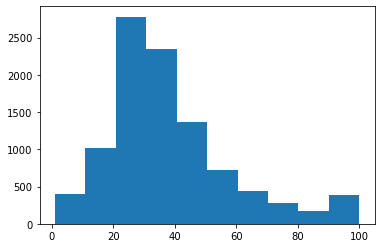

In [372]:
plt.hist(train_df['Pawpularity'])
plt.show()

# Pawpularity 점수를 구간별로 나눈뒤 해당 구간에 Binary 데이터들이
# 어떤식으로 분포되어있는지 안다면 예측에 좀더 용이하지 않을까?
# A -> 낮은점수와 높은점수간 데이터의 분포가 다르지 않음


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pawpularity', ylabel='Density'>

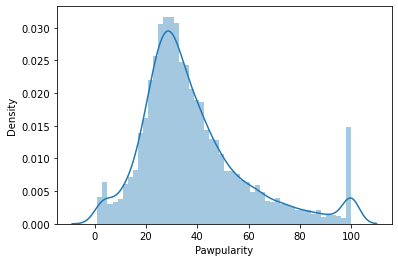

In [198]:
sns.distplot(train_df['Pawpularity'])
# Pawpularity변수는 정규분포로 보임

높은 점수와 낮은 점수의 차이를 살펴보기 위해  
Pawpularty 점수를 0-49(낮음) 50~100(높음)으로 나누어

각 구간에 따른 데이터셋의 분포를 살펴보자


In [284]:
low_paw = train_df.loc[train_df.Pawpularity<50].iloc[:,1:].sample(1000)
high_paw = train_df.loc[(train_df.Pawpularity>=50) & (train_df.Pawpularity <=100)].iloc[:,1:].sample(1000)

<AxesSubplot:>

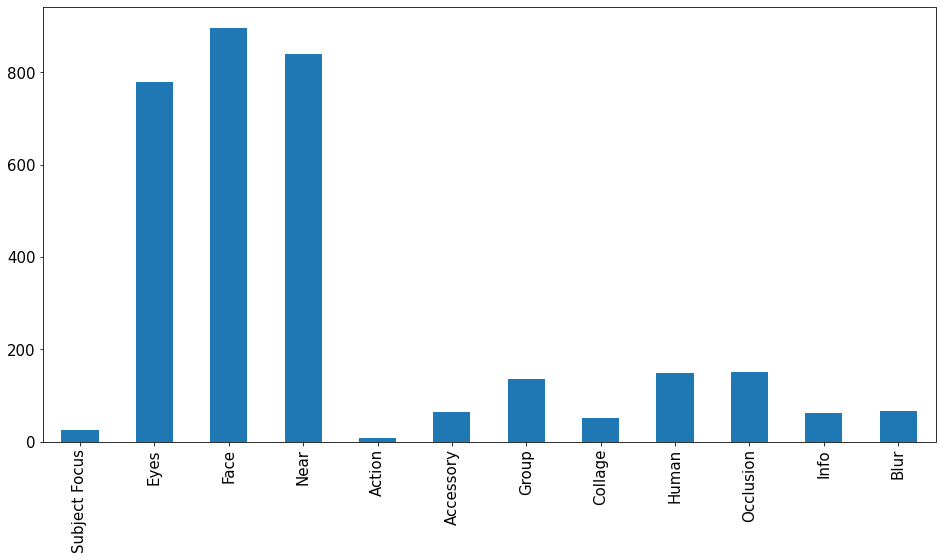

In [287]:
low_paw.iloc[:,:-1].sum().plot.bar(figsize=(16,8),fontsize=15)

<AxesSubplot:>

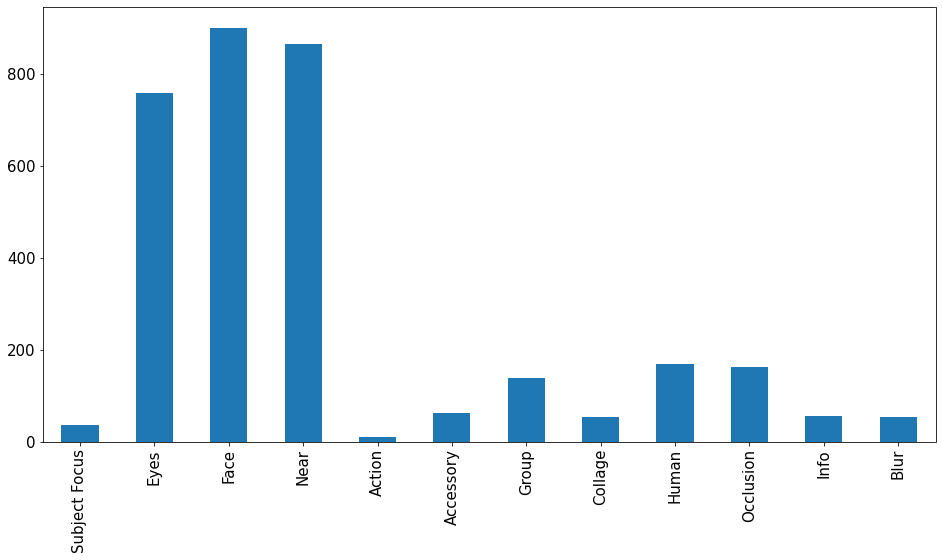

In [288]:
high_paw.iloc[:,:-1].sum().plot.bar(figsize=(16,8),fontsize=15)

현재로써는 Pawpularity 점수와 데이터셋에는 영향이 많이 없어보임

독립변수와 종속변수의 상관관계를 확인

 이산형 -> 연속형이므로 점이연 상관관계(Point biserial correlation)



In [298]:
#pvalue가  .05보다 작을경우 통계적으로 유의, 클경우 유의하지 않음
stats.pointbiserialr(low_paw.iloc[:,1],low_paw.iloc[:,-1])

PointbiserialrResult(correlation=0.12311149570930233, pvalue=9.496271026090912e-05)

In [369]:
corr_list=[]
p_value =[]
for columns in temp.iloc[:,:-1]:
    x = temp[columns]
    corr = stats.pointbiserialr(list(x),list(temp['Pawpularity']))
    if corr[1] < 0.05:
        p_value.append('유의')
    else : 
        p_value.append('유의하지 않음')
    corr_list.append(corr[0])
    
point_corr = pd.DataFrame({'Petpularity' : corr_list, 'P_value' : p_value}).set_index(temp.iloc[:,:-1].columns)
point_corr.sort_values(by=['Petpularity'],axis=0,ascending=False)

,Petpularity,P_value
Group,0.016469,유의하지 않음
Accessory,0.013287,유의하지 않음
Face,0.008018,유의하지 않음
Human,0.003983,유의하지 않음
Occlusion,0.001979,유의하지 않음
Collage,0.001732,유의하지 않음
Near,0.001001,유의하지 않음
Action,-0.001373,유의하지 않음
Info,-0.004735,유의하지 않음
Eyes,-0.006686,유의하지 않음


통계적으로도 유의하지 않으며, 이렇다할 상관관계도 보이지 않음

높은점수와 낮은점수에서의 상관관계는?

In [370]:
corr_list=[]
p_value =[]
for columns in high_paw.iloc[:,:-1]:
    x = high_paw[columns]
    corr = stats.pointbiserialr(list(x),list(high_paw['Pawpularity']))
    if corr[1] < 0.05:
        p_value.append('유의')
    else : 
        p_value.append('유의하지 않음')
    corr_list.append(corr[0])
    
point_corr = pd.DataFrame({'Petpularity' : corr_list, 'P_value' : p_value}).set_index(high_paw.iloc[:,:-1].columns)
point_corr.sort_values(by=['Petpularity'],axis=0,ascending=False)

,Petpularity,P_value
Near,0.050445,유의하지 않음
Accessory,0.041101,유의하지 않음
Human,0.027303,유의하지 않음
Collage,0.017350,유의하지 않음
Blur,-0.000045,유의하지 않음
Action,-0.002125,유의하지 않음
Info,-0.008001,유의하지 않음
Occlusion,-0.013525,유의하지 않음
Face,-0.021941,유의하지 않음
Subject Focus,-0.025605,유의하지 않음


In [371]:
corr_list=[]
p_value =[]
for columns in low_paw.iloc[:,:-1]:
    x = low_paw[columns]
    corr = stats.pointbiserialr(list(x),list(low_paw['Pawpularity']))
    if corr[1] < 0.05:
        p_value.append('유의')
    else : 
        p_value.append('유의하지 않음')
    corr_list.append(corr[0])
    
point_corr = pd.DataFrame({'Petpularity' : corr_list, 'P_value' : p_value}).set_index(low_paw.iloc[:,:-1].columns)
point_corr.sort_values(by=['Petpularity'],axis=0,ascending=False)

,Petpularity,P_value
Eyes,0.123111,유의
Face,0.066868,유의
Group,0.064776,유의
Info,0.050324,유의하지 않음
Occlusion,0.047853,유의하지 않음
Accessory,0.047423,유의하지 않음
Human,0.006104,유의하지 않음
Collage,-0.003530,유의하지 않음
Action,-0.021238,유의하지 않음
Near,-0.025386,유의하지 않음


역시나 이렇다할 상관관계는 보이지 않는다

컬럼만으로 정확한 점수를 예측하는것에는 무리가 있어보이나

일단 예측을 시도해보자